# PCA on Ridle and sentence embeddings

### Tobi's Code

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Reading Data...
Processing Data...


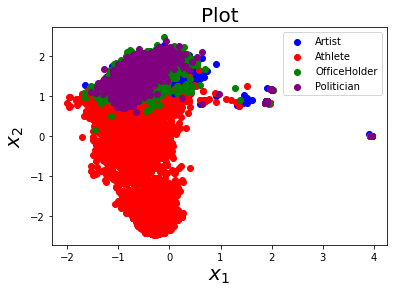

In [2]:
# Load Representations
print('Reading Data...')
df = pd.read_csv('./dataset/{}/embedding.csv'.format('Person_DBpedia'))

# Load mapping: Choose either dbpedia or wikidata mapping
mapping = pd.read_json('./dataset/dbp_type_mapping.json')
#mapping = pd.read_json('./dataset/wd_mapping_type.json')


# merge them
print('Processing Data...')
r = pd.merge(df, mapping, on='S').drop(['S'], axis=1).explode('Class')

# Filter for classes
r = r[r['Class'].isin(['Athlete', 'Politician', 'Artist', 'OfficeHolder'])].reset_index(drop=True)

colors = ['blue', 'red', 'green', 'purple', 'cyan']
# Apply PCA
pca = PCA(n_components=2)
x = pca.fit_transform(r.drop(['Class'], axis=1))
df = pd.DataFrame(x)

# create plots
fig, ax = plt.subplots()
for idx, c in enumerate(r['Class'].unique()):
    df_tmp = df[df.index.isin(r[r['Class'] == c].index)].values
    ax.scatter(df_tmp[:,0], df_tmp[:,1], color=colors[idx], label=c)




ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title('Plot', fontsize=20)
ax.legend()
plt.show()


### Ridle & sentence embeddings with cleaned testset

In [3]:
import argparse
parser = argparse.ArgumentParser(
    description='Instance Type Prediction using Ridle',
)
parser.add_argument('--dataset', nargs='?', default='Person_DBpedia', type=str)
#parser.add_argument('--dataset', nargs='?', default='DBp_2016-04', type=str)
parser, unknown = parser.parse_known_args()

print('Reading Data...')
df = pd.read_csv('./dataset/{}/embedding.csv'.format(parser.dataset))

# Load mapping
if 'dbp' in parser.dataset.lower():
    mapping = pd.read_json('./dataset/dbp_type_mapping.json')
elif 'wd' in parser.dataset.lower() or 'wikidata' in parser.dataset.lower():
    mapping = pd.read_json('./dataset/wd_mapping_type.json')
else:
    mapping = pd.read_json('./dataset/{}/type_mapping.json'.format(parser.dataset))

# merge them
print('Processing Data...')
r = pd.merge(df, mapping, on='S')

#input_data = pd.read_pickle('./dataset/{}/input_data_unclean.pkl'.format(parser.dataset))
input_data = pd.read_pickle('./dataset/{}/input_data_summary_full.pkl'.format(parser.dataset))

Reading Data...
Processing Data...


In [4]:
non_empty = input_data[input_data.Summary!='']
r_copy = r.copy()
r_new = r_copy[r_copy.S.isin(non_empty['S'].values)]
input_new = input_data[input_data.S.isin(non_empty['S'].values)]
text = input_new['Summary']
sentences = ["" + temp + "" for temp in text]
inputs = r_new.drop(['S', 'Class'], axis=1).values
r_new = r_new.reset_index(drop=True)

### Sentence-BERT 

In [5]:
from sentence_embeddings import Sentence_Embedder
s = Sentence_Embedder(model_name="all-mpnet-base-v2")
s = Sentence_Embedder(model_name="all-MiniLM-L6-v2")
embeddings = s.embed(sentences)

### Universal Sentence Encoder

In [4]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)
embeddings = embed(sentences)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Create Embeddings

In [7]:
embeddings = np.array(embeddings)
i = 0
dict_embeddings = {}
for entity in input_new["S"]:
    dict_embeddings[entity] = [embeddings[i]]
    i+=1

In [8]:
inputs = np.array(inputs)
ridle_dict = {}
i=0
for entity in r_new['S']:
    ridle_dict[entity] = [inputs[i]]
    i+=1

In [9]:
import numpy as np
ds = [ridle_dict, dict_embeddings]
d = {}
for k in ridle_dict.keys():
    d[k] = tuple(d[k] for d in ds)

In [10]:
resources = d.keys()

In [11]:
conc_input =  []
for key in d:
    conc_input.append(np.concatenate((d[key][0][0], d[key][1][0])))
conc_input = np.array(conc_input)

In [12]:
#creates conc_input as a panda DataFrame
conc = pd.DataFrame(conc_input)

In [13]:
#resets the index so the index order is correct
conc.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,424,425,426,427,428,429,430,431,432,433
0,7.631720e-01,1.0,4.887698e-19,3.311328e-01,1.855957e-01,9.208964e-01,8.869670e-01,7.170866e-01,9.967960e-01,2.000936e-04,...,0.051922,-0.021340,-0.034916,-0.021728,-0.030944,0.025113,0.036412,-0.153728,0.007917,-0.001309
1,1.867724e-01,1.0,1.244400e-22,9.927385e-01,1.448587e-01,1.036931e-02,9.882645e-01,5.870160e-02,2.780135e-01,1.240314e-07,...,0.032966,-0.022344,-0.089715,-0.003034,0.048888,0.030445,-0.023303,-0.071808,0.058804,0.013486
2,7.483270e-20,1.0,6.233488e-10,1.278967e-15,9.999894e-01,6.530746e-09,1.000000e+00,2.254979e-05,1.061634e-05,1.797134e-07,...,-0.046757,-0.012012,-0.071476,0.062331,-0.037960,-0.023151,0.084433,0.030587,-0.007113,-0.031164
3,2.962029e-55,1.0,8.954294e-24,1.489531e-32,5.827274e-14,3.088779e-37,1.000000e+00,1.317564e-25,2.372466e-19,7.726750e-12,...,-0.025475,0.071724,-0.038495,0.033753,-0.055058,-0.065378,0.065458,0.066789,0.017348,-0.005996
4,2.319130e-55,1.0,2.703718e-25,2.069739e-33,2.127550e-13,3.449957e-35,1.000000e+00,2.030557e-24,5.642201e-21,3.439646e-12,...,-0.025663,0.021371,-0.042641,0.043718,-0.054513,-0.074031,0.015926,0.052155,0.015304,0.043524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29890,6.384771e-01,1.0,4.085131e-05,9.998888e-01,9.999642e-01,9.671814e-13,5.099104e-09,1.096196e-10,1.215264e-02,9.999260e-01,...,0.046044,0.047893,-0.029949,-0.028991,-0.009939,-0.021457,0.003730,-0.011845,0.085149,-0.005250
29891,9.709537e-01,1.0,4.675447e-03,9.965025e-01,9.998476e-01,4.849877e-08,4.392478e-01,5.152469e-18,9.896307e-01,6.714229e-01,...,-0.028034,0.051512,-0.074109,-0.050239,0.063067,0.039620,0.010292,-0.035064,-0.036618,-0.095629
29892,2.628005e-01,1.0,1.529116e-18,7.155028e-01,3.926082e-03,1.403661e-03,9.260512e-01,9.183734e-01,9.584211e-01,2.097722e-08,...,0.072170,-0.076236,-0.044965,0.007856,-0.040698,0.004948,0.030670,0.040673,0.019679,-0.041325
29893,5.790589e-02,1.0,2.588590e-12,9.739352e-01,2.668532e-16,3.335196e-01,1.010085e-04,2.040214e-05,9.341979e-01,9.546175e-01,...,-0.015978,-0.048434,0.044629,0.022562,-0.044872,0.072484,-0.004543,-0.084521,-0.006593,-0.046198


In [14]:
#adds the resource to the conc_input dataFrame
conc["S"] = resources

In [15]:
classes = r_new["Class"]

In [16]:
#adds the classes to the conc_input dataFrame
conc["Class"] = classes

## For Ridle Embeddings

In [22]:
#splits up entity into every single class, so if entity has 4 classes, it creates 4 instances of the entity,
#copies the entities features, and puts each instance into only 1 Class so we don't have a list anymore
r_new = r_new.drop(['S'], axis=1).explode('Class')

In [23]:
#removes instances that are not in Class Species,agent...
#r_new = r_new[r_new['Class'].isin(['Species', 'Agent', 'Work', 'Place'])].reset_index(drop=True)
r_new = r_new[r_new['Class'].isin(['Athlete', 'Politician', 'Artist', 'OfficeHolder'])].reset_index(drop=True)

In [50]:
#rename to use it in PCA
conc_new = r_new

## For Concatenated Embeddings

In [38]:
#Forget about this cell
#conc_test = conc_test[conc_test['Class'].isin(['Species', 'Agent', 'Work', 'Place'])].reset_index(drop=True)
conc_test = conc_test[conc_test['Class'].isin(['Athlete', 'Politician', 'Artist', 'OfficeHolder'])].reset_index(drop=True)
conc_new = conc_test

NameError: name 'conc_test' is not defined

In [39]:
#Again explode does the same as above, and then removes entities, that do not belong to athlete,...
conc_new = conc
conc_new = conc_new.drop(["S"], axis=1).explode("Class")
#conc_new = conc_new
conc_new = conc_new[conc_new['Class'].isin(['Athlete', 'Politician', 'Artist', 'OfficeHolder'])].reset_index(drop=True)


In [40]:
conc_new

,0,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,Class
0,0.763172,1.0,4.887698e-19,0.331133,0.185596,9.208964e-01,8.869670e-01,7.170866e-01,0.996796,2.000936e-04,...,-0.021340,-0.034916,-0.021728,-0.030944,0.025113,0.036412,-0.153728,0.007917,-0.001309,Artist
1,0.186772,1.0,1.244400e-22,0.992739,0.144859,1.036931e-02,9.882645e-01,5.870160e-02,0.278013,1.240314e-07,...,-0.022344,-0.089715,-0.003034,0.048888,0.030445,-0.023303,-0.071808,0.058804,0.013486,Artist
2,0.978483,1.0,2.947811e-28,0.996597,0.066297,1.960950e-02,7.597246e-01,1.334626e-01,0.178113,7.717462e-09,...,-0.059175,-0.078575,-0.003548,-0.015877,-0.067427,0.036310,-0.047072,-0.023202,0.039598,Artist
3,0.898526,1.0,1.444410e-22,0.962724,0.000074,8.318265e-02,9.909417e-01,5.171523e-01,0.999311,5.417700e-08,...,-0.012912,-0.064032,-0.015555,0.080867,0.012007,-0.004468,0.007986,0.021823,-0.170113,Artist
4,0.373435,1.0,2.527035e-23,0.568030,0.001294,8.783112e-01,9.998120e-01,1.529112e-01,0.999651,2.804033e-06,...,-0.028451,-0.034886,0.034994,-0.073446,-0.027214,0.027721,-0.075674,-0.009593,-0.055653,Artist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18917,0.890999,1.0,8.973265e-01,0.999935,0.999637,9.341403e-17,1.400261e-12,5.600797e-10,0.002869,9.999966e-01,...,0.013176,-0.097880,-0.048792,-0.024780,-0.034094,0.020249,-0.038648,0.065898,-0.011286,Athlete
18918,0.638477,1.0,4.085131e-05,0.999889,0.999964,9.671814e-13,5.099104e-09,1.096196e-10,0.012153,9.999260e-01,...,0.047893,-0.029949,-0.028991,-0.009939,-0.021457,0.003730,-0.011845,0.085149,-0.005250,Athlete
18919,0.970954,1.0,4.675447e-03,0.996503,0.999848,4.849877e-08,4.392478e-01,5.152469e-18,0.989631,6.714229e-01,...,0.051512,-0.074109,-0.050239,0.063067,0.039620,0.010292,-0.035064,-0.036618,-0.095629,Politician
18920,0.262800,1.0,1.529116e-18,0.715503,0.003926,1.403661e-03,9.260512e-01,9.183734e-01,0.958421,2.097722e-08,...,-0.076236,-0.044965,0.007856,-0.040698,0.004948,0.030670,0.040673,0.019679,-0.041325,Artist


## Plot the class distribution

In [52]:
colors = ['red', 'cyan', 'green', 'blue', 'purple']
# Apply PCA
pca = PCA(n_components=2)
x = pca.fit_transform(conc_new.drop(['Class'], axis=1))
df = pd.DataFrame(x)
df_tmp = df[df.index.isin(conc_new[conc_new['Class'] == c].index)].values
df
# # create plot
# fig, ax = plt.subplots()
# for idx, c in enumerate(conc_new['Class'].unique()):
#     df_tmp = df[df.index.isin(conc_new[conc_new['Class'] == c].index)].values
#     ax.scatter(df_tmp[:,0], df_tmp[:,1], color=colors[idx], label=c, s=0.5)

# ax.set_xlabel('$x_1$', fontsize=20)
# ax.set_ylabel('$x_2$', fontsize=20)
# ax.set_title('SBERT+Ridle vectors on Person_DBpedia', fontsize=15)
# ax.legend(markerscale=5., scatterpoints=1, fontsize=10, )
# #plt.savefig('Test1_person_Sbert.png', dpi = 300)
# plt.show()


,0,1
0,-1.249655,-1.229397
1,-1.173927,-0.517059
2,-1.028549,-0.761918
3,-1.031241,-1.254312
4,-1.459366,-1.259043
...,...,...
18917,2.379581,0.601657
18918,1.686773,0.205454
18919,-1.587133,1.183415
18920,-1.036020,-0.931851


In [ ]:
array([-1.05005085, -0.78993381])